# Dimensionality reduction for visualizing high dimensional data

This notebook showcases how Principal Component Analysis (PCA) and T-SNE can be used to reduce the dimensionality of high dimensional data for visualization in 2d space. The principal components matrix will be constructed manually with the use of Singular Value Decomposition. For T-SNE a ready-made class from Scikit-Learn will be used.

The dataset used here is the fashion-MNIST dataset of 28x28 grayscale images of fashion items in 10 discrete classes. The dataset follows closely the famous MNIST dataset for handwritten digits and same data loaders and data preprocessing workarounds can be used here as with the original MNIST dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mnist_reader import load_mnist
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## 1. Loading and subsetting the dataset

We will use a a helper module mnist_reader.py to load the dataset. For this task we are only interested of a visualizing a selected subset of data classes. The selected classes are as follows: 5 (“sandal”), 7 (“sneaker”), and 9 (“ankle_boots”). We will load both the training and testing subsets, but later we will only use the data in test set due to computing limitations.

In [3]:
labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

X_train, y_train = load_mnist("data/fashion_mnist/", kind="train")
X_test, y_test = load_mnist("data/fashion_mnist/", kind="t10k")
print(f"Training set shape: {X_train.shape}", f"\nTesting set shape: {X_test.shape}\n")

train_mask0 = (y_train == labels.index("sandal"))
train_mask1 = (y_train == labels.index("sneaker"))
train_mask2 = (y_train == labels.index("ankle_boots"))
train_mask = train_mask0 | train_mask1 | train_mask2
assert train_mask0.sum()+train_mask1.sum()+train_mask2.sum() == train_mask.sum(), "Masks should be mutually independent"
test_mask0 = (y_test == labels.index("sandal"))
test_mask1 = (y_test == labels.index("sneaker"))
test_mask2 = (y_test == labels.index("ankle_boots"))
test_mask = test_mask0 | test_mask1 | test_mask2
assert test_mask0.sum()+test_mask1.sum()+test_mask2.sum() == test_mask.sum(), "Masks should be mutually independent"

X_train, y_train = X_train[train_mask], y_train[train_mask]
X_test, y_test = X_test[test_mask], y_test[test_mask]
print(f"Subsetted training set shape: {X_train.shape}", f"\nSubsetted testing set shape: {X_test.shape}\n")

Training set shape: (60000, 784) 
Testing set shape: (10000, 784)

Subsetted training set shape: (18000, 784) 
Subsetted testing set shape: (3000, 784)



## 2. Construct PCA with the use of SVD

1. In PCA we want to center the data so that all feature columns have a mean of approx. zero. 
2. Testing set matrix gets is factorized into unitary matrices _U_ and _Vh_ and vector _s_ of singular values
3. Test that original matrix can be reconstructed with product of _U_, _S_\_ and _Vh_ where S_ is a rectangular diagonal matrix with values from s on the main diagonal
4. Construct principal components matrix with two principal components by taking product of _U_[:, :2] and _s_[:2]

In [4]:
# 1. center data
X_test_means = X_test.mean(axis=0)
X_test = X_test - X_test_means

In [5]:
# 2. Use SVD to factorize matrix X_test into U, s, Vh such that X_test == U @ S_ @ Vh
U, s, Vh = linalg.svd(X_test)
# S_ = rectangular diagonal matrix with S_(i, i) = s[i]
S_ = np.zeros(X_test.shape)
for i in range(min(*X_test.shape)):
    S_[i, i] = s[i]

print(f"Shapes, U: {U.shape}, s: {s.shape}, Vh: {Vh.shape}, S_: {S_.shape}")

# 3. Test that reverse constructing original matrix from U, S_ and Vh is correct
tmp_a = np.dot(U, np.dot(S_, Vh))
assert np.allclose(X_test, tmp_a), "Matrix decomposition-construction failed."

Shapes, U: (3000, 3000), s: (784,), Vh: (784, 784), S_: (3000, 784)


In [6]:
# 4. Select n=2 principal components of X_test for analysis
n_components = 2
pca_mtx = U[:, :n_components]
pca_mtx = pca_mtx * s[:n_components]

## 3. Plot the data points based on the two principal components

Data in the following plot is presented in terms of the first two principal components. Data classes for samples are color-coded as follows:
  * <span style="color:red">**Red**</span>: sandal
  * <span style="color:green">**Green**</span>: sneaker
  * <span style="color:blue">**Blue**</span>: ankle boots

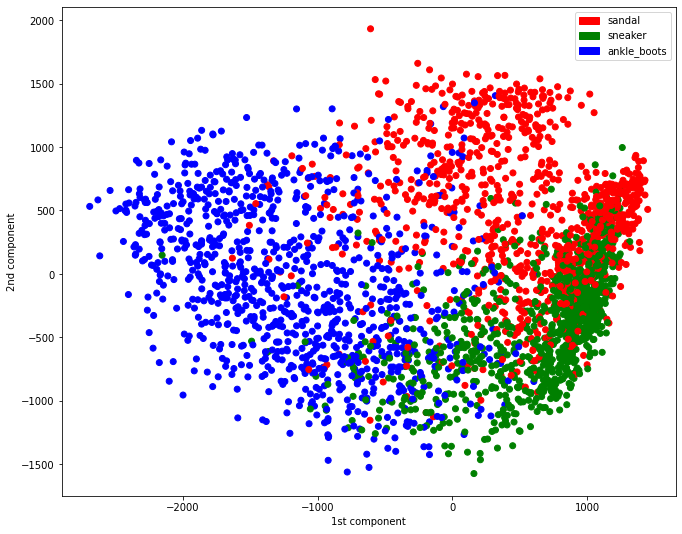

In [8]:
def get_colors(y):
    colors = {
        5: "red",
        7: "green",
        9: "blue"
    }
    return [colors[c] for c in y]


r_patch = mpatches.Patch(color='red', label=labels[5])
g_patch = mpatches.Patch(color='green', label=labels[7])
b_patch = mpatches.Patch(color='blue', label=labels[9])

plt.figure(figsize=(11, 9))
plt.scatter(pca_mtx[:, 0], pca_mtx[:, 1], c=get_colors(y_test))
plt.ylabel("2nd component")
plt.xlabel("1st component")
plt.legend(handles=[r_patch, g_patch, b_patch])
plt.show()

## 4. Plot the data with t-SNE

We now plot the data using a Scikit-Learn implementation of t-distributed stochastic neighbor embedding (t-SNE). T-SNE is a nonlinear dimensionality technique (whereas PCA is linear) and therefore provides a great alternative to visualize data when the underlying patterns cannot be explained with linear relations. Just like in the case of PCA, we will be selecting top 2 components for t-SNE in order to present the data in 2d space.

Data classes for samples are color-coded as follows:
  * <span style="color:red">**Red**</span>: sandal
  * <span style="color:green">**Green**</span>: sneaker
  * <span style="color:blue">**Blue**</span>: ankle boots

In [11]:
tsne = TSNE(n_components=2)
tsne_mtx = tsne.fit_transform(X_test)

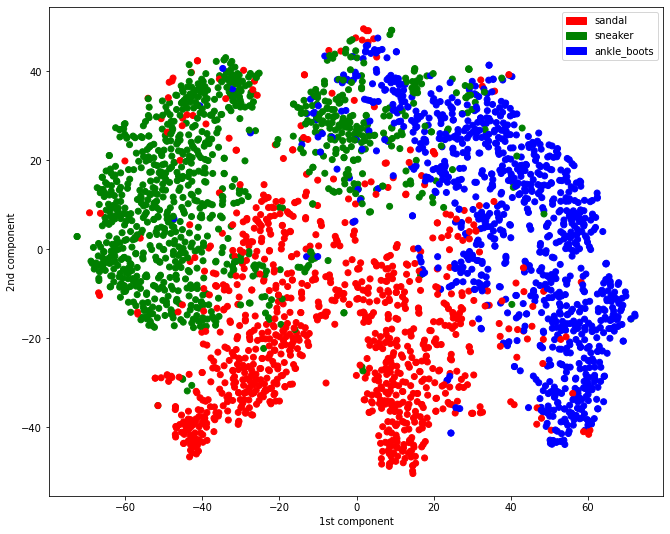

In [12]:
def get_colors(y):
    colors = {
        5: "red",
        7: "green",
        9: "blue"
    }
    return [colors[c] for c in y]


r_patch = mpatches.Patch(color='red', label=labels[5])
g_patch = mpatches.Patch(color='green', label=labels[7])
b_patch = mpatches.Patch(color='blue', label=labels[9])

plt.figure(figsize=(11, 9))
plt.scatter(tsne_mtx[:, 0], tsne_mtx[:, 1], c=get_colors(y_test))
plt.ylabel("2nd component")
plt.xlabel("1st component")
plt.legend(handles=[r_patch, g_patch, b_patch])
plt.show()